In [3]:
import numpy as np
import pandas as pd

In [4]:
!pip install chardet

In [5]:
import chardet

# Detect file encoding
with open('spam.csv', 'rb') as file:
    result = chardet.detect(file.read())
    print(result)

{'encoding': 'Windows-1252', 'confidence': 0.7269493857068697, 'language': ''}


In [6]:
df = pd.read_csv('spam.csv', encoding='Windows-1252')

In [7]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
4280,ham,"Wn u r hurt by d prsn who s close 2 u, do figh...",NaN,NaN,NaN
2362,ham,How are you doing? Hope you've settled in for ...,NaN,NaN,NaN
2072,ham,That is wondarfull song,NaN,NaN,NaN
582,spam,We tried to contact you re your reply to our o...,NaN,NaN,NaN
934,spam,Dear Matthew please call 09063440451 from a la...,NaN,NaN,NaN


In [8]:
df.shape

(5572, 5)

Steps:
1) Data cleaning
2) EDA
3) text preprocessing
4) model buiding
5) evalutaion
6) improvements
7) Website
8) deploy

## 1) Data Cleaning

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


-----> we will drop last three columns because there are very few non null values present.

In [10]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [11]:
df.sample(5)

,v1,v2
4197,spam,Want to funk up ur fone with a weekly new tone...
1949,ham,Wait 2 min..stand at bus stop
4891,ham,Miserable. They don't tell u that the side eff...
4101,ham,Ok then i will come to ur home after half an hour
642,ham,Probably gonna swing by in a wee bit


In [12]:
# renaming the coloumns
df.rename(columns={'v1': 'target','v2': 'text'},inplace=True)

In [13]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [14]:
df['target'] = encoder.fit_transform(df['target'])

In [15]:
df.sample(5)

,target,text
642,0,Probably gonna swing by in a wee bit
4643,0,Did u got that persons story
3323,0,I don wake since. I checked that stuff and saw...
3134,0,Wat makes some people dearer is not just de ha...
471,0,"How long has it been since you screamed, princ..."


In [16]:
# missing value check
df.isnull().sum()

target    0
text      0
dtype: int64

In [17]:
#check for duplicate values
df.duplicated().sum()

np.int64(403)

In [18]:
# remove duplicates
df = df.drop_duplicates(keep='first')

In [19]:
df.duplicated().sum()

np.int64(0)

## 2) Exploratory Data Analysis

In [20]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

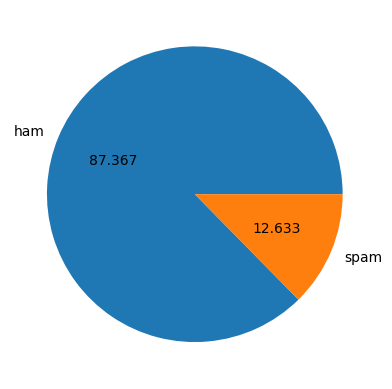

In [21]:
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(), labels=['ham','spam'], autopct="%0.3f")
plt.show()

from above we can say that data is inbalanced

In [22]:
import nltk

In [23]:
nltk.download('punkt') # punkt is tokenizer model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jimit_moontechnolabs\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
df['num_characters'] = df['text'].apply(len)

In [25]:
df.sample(5)

,target,text,num_characters
1549,0,Dude sux for snake. He got old and raiden got ...,50
5222,0,5 nights...We nt staying at port step liao...T...,51
2312,1,tddnewsletter@emc1.co.uk (More games from TheD...,114
2794,0,How will I creep on you now? ;_;,32
2049,0,How much is blackberry bold2 in nigeria.,40


In [26]:
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [27]:
df.head()

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [28]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [29]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [30]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [31]:
# for ham messages
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [32]:
# for spam messages
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


In [33]:
!pip install seaborn

In [34]:
import seaborn as sns

<Axes: xlabel='num_characters', ylabel='Count'>

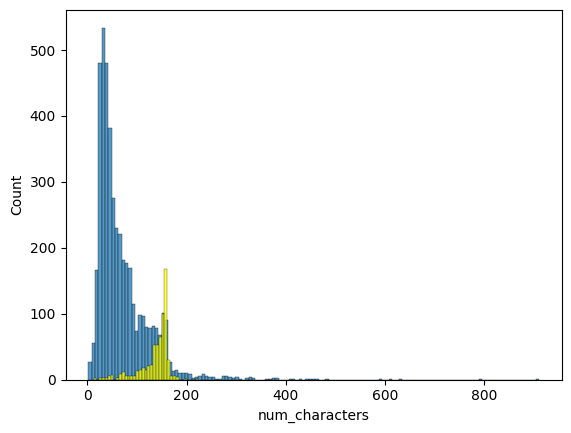

In [35]:
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'], color='yellow')

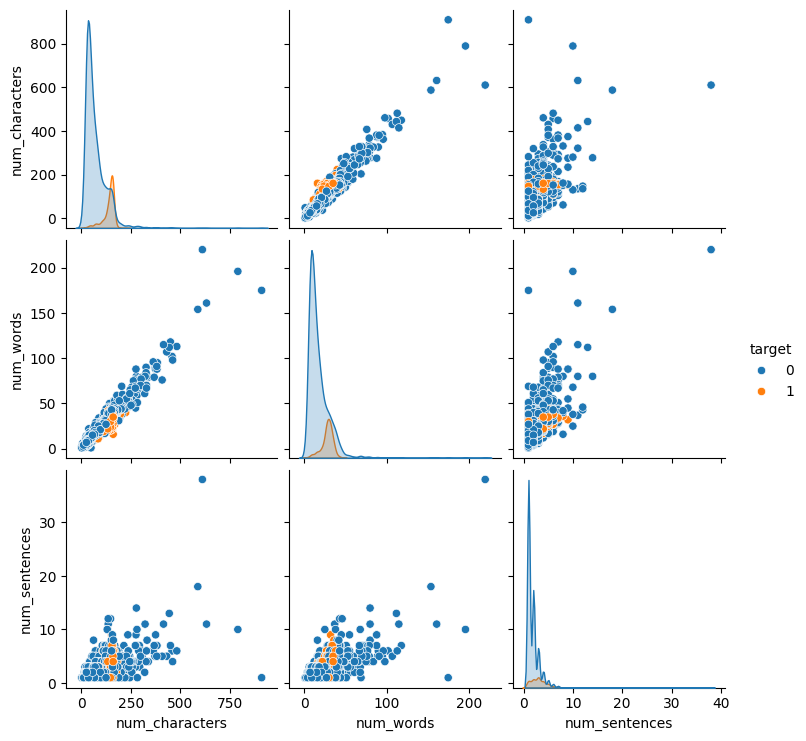

In [36]:
# relation of columns
sns.pairplot(df,hue='target')

In [37]:
df_numeric = df.select_dtypes(include=[np.number])

<Axes: >

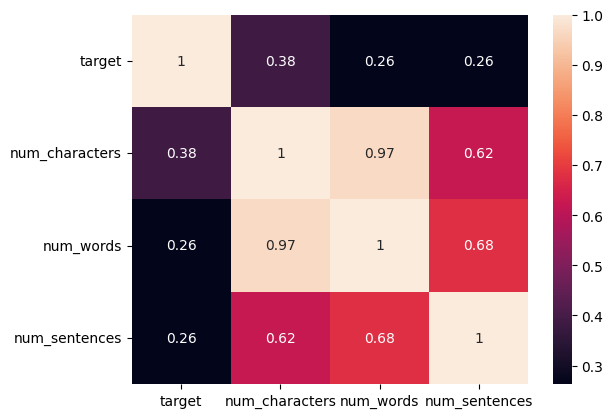

In [38]:
sns.heatmap(df_numeric.corr(), annot=True)

## 3) Data Preprocessing(Text preprocessing)
    ->Lower case
    ->Tokenization
    ->removing special characters
    ->removing stop words and punctuation
    ->stemming

In [39]:
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer

ps = PorterStemmer()

In [40]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    # text is coverted in list because of tokenization process.
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))
    return " ".join(y)  # returning as a string

In [41]:
df['transformed_text'] = df['text'].apply(transform_text)

In [42]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [81]:
!pip install wordcloud

In [43]:
# displays important words as big size
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [44]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

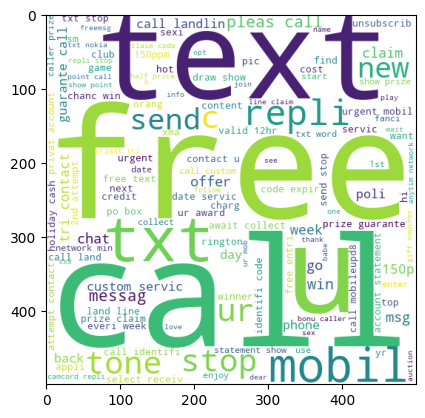

In [45]:
plt.imshow(spam_wc)

In [46]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

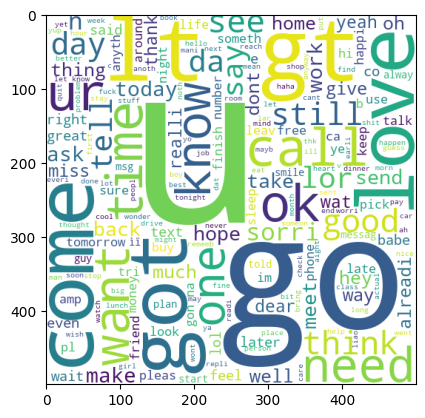

In [47]:
plt.imshow(ham_wc)

In [48]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [49]:
len(spam_corpus)

9939

In [50]:
Counter(spam_corpus).most_common(50)

NameError: name 'Counter' is not defined

In [51]:
from collections import Counter
pd.DataFrame(Counter(spam_corpus).most_common(30))

,0,1
0,call,320
1,free,191
2,2,155
3,txt,141
4,text,122
5,u,119
6,ur,119
7,mobil,114
8,stop,104
9,repli,103


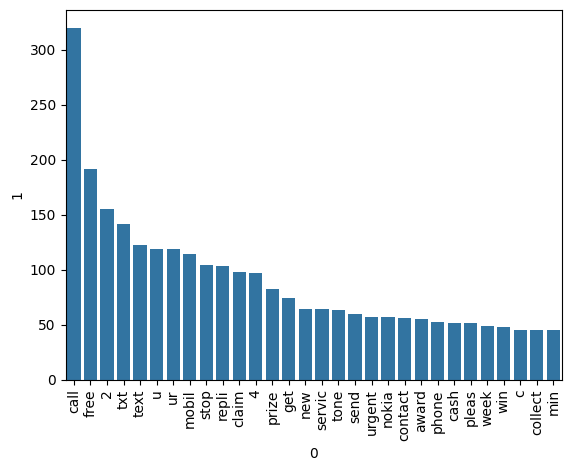

In [52]:
sns.barplot(x=0, y=1, data=pd.DataFrame(Counter(spam_corpus).most_common(30)))
plt.xticks(rotation='vertical')
plt.show()

## 4) Model Bulding

In [53]:
from sklearn.feature_extraction.text import CountVectorizer # bag of word is used over here
cv = CountVectorizer()

In [54]:
X = cv.fit_transform(df['transformed_text']).toarray()

In [55]:
X.shape

(5169, 6708)

In [56]:
y = df['target'].values

In [57]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [60]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [61]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [62]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8800773694390716
[[792 104]
 [ 20 118]]
0.5315315315315315


In [63]:
mnb.fit(X_train,y_train)
y_pred1 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.9642166344294004
[[871  25]
 [ 12 126]]
0.8344370860927153


In [64]:
bnb.fit(X_train,y_train)
y_pred1 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))
# for inbalance dataset focus on precision score more compare to accuracy score

0.9700193423597679
[[893   3]
 [ 28 110]]
0.9734513274336283


In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer #TFIDF is used
tfidf = TfidfVectorizer()

In [66]:
x1 = tfidf.fit_transform(df['transformed_text']).toarray()
y1 = df['target'].values

In [67]:
X_train,X_test,y_train,y_test = train_test_split(x1,y1,test_size=0.2,random_state=2)

In [68]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8762088974854932
[[793 103]
 [ 25 113]]
0.5231481481481481


In [69]:
mnb.fit(X_train,y_train)
y_pred1 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.9593810444874274
[[896   0]
 [ 42  96]]
1.0


In [70]:
bnb.fit(X_train,y_train)
y_pred1 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.9700193423597679
[[893   3]
 [ 28 110]]
0.9734513274336283


In [71]:
# tfidf --> mnb

In [150]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
    --------------------------------------- 1.6/124.9 MB 7.6 MB/s eta 0:00:17
   - -------------------------------------- 3.7/124.9 MB 7.8 MB/s eta 0:00:16
   -- ------------------------------------- 6.8/124.9 MB 10.8 MB/s eta 0:00:11
   --- ------------------------------------ 9.4/124.9 MB 10.9 MB/s eta 0:00:11
   --- ------------------------------------ 12.1/124.9 MB 11.1 MB/s eta 0:00:11
   ---- ----------------------------------- 14.4/124.9 MB 11.2 MB/s eta 0:00:10
   ----- ---------------------------------- 17.0/124.9 MB 11.3 MB/s eta 0:00:10
   ------ --------------------------------- 19.4/124.9 MB 11.3 MB/s eta 0:00:10
   ------ --------------------------------- 21.8/124.9 MB 11.4 MB/s eta 0:00:10
   ------- -------------------------------- 24.1/124.9 MB 11.5 MB/s eta 0:00:09
   -------- ------------------------------- 26.5/124.9 MB 11.5 M

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [73]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [74]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [75]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [76]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9729206963249516
Precision -  0.9741379310344828
For  KN
Accuracy -  0.9003868471953579
Precision -  1.0
For  NB
Accuracy -  0.9593810444874274
Precision -  1.0
For  DT
Accuracy -  0.9361702127659575
Precision -  0.8461538461538461
For  LR
Accuracy -  0.9516441005802708
Precision -  0.94
For  RF
Accuracy -  0.971953578336557
Precision -  1.0


C:\Users\jimit_moontechnolabs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


For  AdaBoost
Accuracy -  0.9613152804642167
Precision -  0.9454545454545454
For  BgC
Accuracy -  0.9584139264990329
Precision -  0.8625954198473282
For  ETC
Accuracy -  0.9729206963249516
Precision -  0.9824561403508771
For  GBDT
Accuracy -  0.9526112185686654
Precision -  0.9238095238095239
For  xgb
Accuracy -  0.9729206963249516
Precision -  0.9435483870967742


In [77]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [78]:
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.900387,1.000000
2,NB,0.959381,1.000000
5,RF,0.971954,1.000000
8,ETC,0.972921,0.982456
0,SVC,0.972921,0.974138
6,AdaBoost,0.961315,0.945455
10,xgb,0.972921,0.943548
4,LR,0.951644,0.940000
9,GBDT,0.952611,0.923810
7,BgC,0.958414,0.862595


## 6) Improvements

In [79]:
"""
1) while creating object of tfidf add one parameter max_features=3000, this will only take most used 3000 words and not all words present in transformed_text
2) Scaling:
    scaler = MinMaxScaler(), naive bayes doesn't accept negative values that's why standard scaler is not used
    X = scaler.fit_transform(X)
3) we can append num_character columns to X and then do evaluation but for this perticular case there is not any improvements
4) voting classifier: combination of best performing algorithms.
5) stacking: same as voting classifier but weitage will be given to each algo.
""" 

"\n1) while creating object of tfidf add one parameter max_features=3000, this will only take most used 3000 words and not all words present in transformed_text\n2) Scaling:\n    scaler = MinMaxScaler(), naive bayes doesn't accept negative values that's why standard scaler is not used\n    X = scaler.fit_transform(X)\n3) we can append num_character columns to X and then do evaluation but for this perticular case there is not any improvements\n4) voting classifier: combination of best performing algorithms.\n5) stacking: same as voting classifier but weitage will be given to each algo.\n"

In [80]:
pip list

Package                   Version
------------------------- --------------
anyio                     4.6.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     24.2.0
babel                     2.16.0
beautifulsoup4            4.12.3
bleach                    6.1.0
certifi                   2024.8.30
cffi                      1.17.1
chardet                   5.2.0
charset-normalizer        3.3.2
click                     8.1.7
collection                0.1.6
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.3.0
cycler                    0.12.1
debugpy                   1.8.5
decorator                 5.1.1
defusedxml                0.7.1
distlib                   0.3.8
executing                 2.1.0
fastjsonschema            2.20.0
filelock                  3.16.1
fonttools                 4.54.0
fqdn           

In [81]:
import pickle
pickle.dump(tfidf, open('vectorizer.pkl','wb'))
pickle.dump(rfc,open('model.pkl','wb'))